# Cell 1: Install Dependencies


In [1]:
!pip install numpy pandas scikit-learn xgboost shap lime matplotlib seaborn plotly streamlit

^C


# Cell 2: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import shap
from lime.lime_tabular import LimeTabularExplainer

c:\Users\mgkul\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cell 3: Load and Explore Dataset

In [ ]:
diabetes_dataset = pd.read_csv("C:\\Users\\mgkul\\Desktop\\diabetes dataset pbl.csv")  # Update this path

print("Dataset shape:", diabetes_dataset.shape)
print("\nFirst 5 rows:")
print(diabetes_dataset.head())
print("\nDataset info:")
print(diabetes_dataset.describe())
print("\nOutcome distribution:")
print(diabetes_dataset['Outcome'].value_counts())

Dataset shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset info:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   

# Cell 4: Data Preparation

In [ ]:
# Split features and target
X = diabetes_dataset.drop(columns='Outcome', axis=1)
y = diabetes_dataset['Outcome']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (614, 8)
Test set size: (154, 8)


# Cell 5: Feature Scaling

In [ ]:
# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")

Features scaled successfully


# Cell 6: SVM Model with Hyperparameter Tuning

In [ ]:
# Define hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}
# Grid search with cross-validation
grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm = grid.best_estimator_
svm_pred = best_svm.predict(X_test_scaled)

print("Best SVM Parameters:", grid.best_params_)
print(f"SVM Accuracy: {accuracy_score(y_test, svm_pred)*100:.2f}%")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVM Accuracy: 71.43%


# Cell 7: Random Forest Model (Main Model for XAI)

In [ ]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred)*100:.2f}%")
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, rf_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 74.68%
Random Forest ROC-AUC: 0.815

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



# Cell 8: XGBoost Model (Comparison)

In [ ]:
# Train XGBoost model
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred)*100:.2f}%")

XGBoost Accuracy: 75.32%


# Cell 9: Cross-Validation

In [ ]:
# Evaluate Random Forest with cross-validation
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print(f"Random Forest CV Accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*2*100:.2f}%)")


Random Forest CV Accuracy: 77.04% (+/- 6.63%)


# Cell 10: SHAP Analysis Setup

In [ ]:
# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test_scaled, check_additivity=False)

# Debug: Check the structure of shap_values
print(f"Type of shap_values: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"Number of classes: {len(shap_values)}")
    for i, sv in enumerate(shap_values):
        print(f"Class {i} SHAP values shape: {sv.shape}")
else:
    print(f"SHAP values shape: {shap_values.shape}")

# For binary classification, SHAP returns a list with values for each class
# We want the SHAP values for the positive class (diabetes = 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_diabetes = shap_values[1]  # Class 1 (diabetes)
    expected_value = explainer.expected_value[1]
else:
    # If it's not a list or has different structure, use the values directly
    shap_values_diabetes = shap_values
    expected_value = explainer.expected_value

print(f"Final SHAP values shape for diabetes class: {shap_values_diabetes.shape}")
print(f"Expected value for diabetes class: {expected_value}")
print(f"Test data shape: {X_test_scaled.shape}")

Type of shap_values: <class 'numpy.ndarray'>
SHAP values shape: (154, 8, 2)
Final SHAP values shape for diabetes class: (154, 8, 2)
Expected value for diabetes class: [0.65351792 0.34648208]
Test data shape: (154, 8)


# Cell 11: SHAP Global Feature Importance

SHAP values shape: (154, 8, 2)
Test data shape: (154, 8)


<Figure size 1000x800 with 0 Axes>

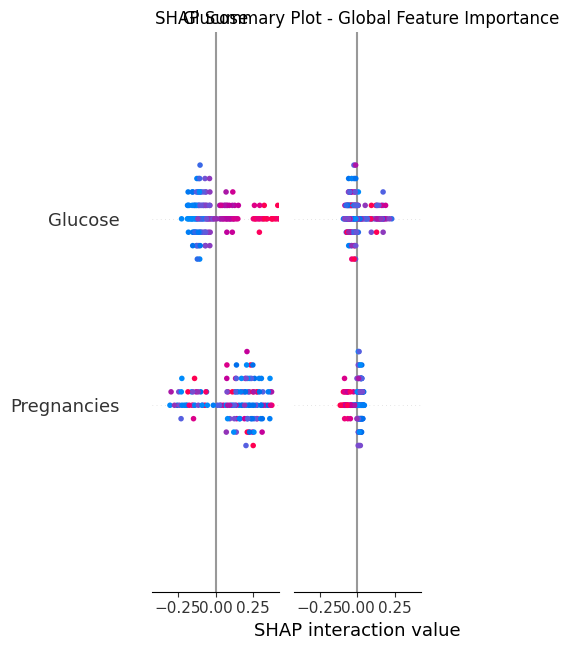

In [ ]:
# Create DataFrame for better visualization (use original unscaled data for interpretability)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Verify shapes match
print(f"SHAP values shape: {shap_values_diabetes.shape}")
print(f"Test data shape: {X_test_df.shape}")

# Summary plot showing global feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_diabetes, X_test_df, show=False)
plt.title("SHAP Summary Plot - Global Feature Importance")
plt.tight_layout()
plt.show()

# Cell 12: SHAP Individual Prediction Explanation

In [ ]:
# Explain individual prediction (first test sample)
instance_idx = 0
print(f"Explaining prediction for test sample {instance_idx}")
print(f"Actual outcome: {y_test.iloc[instance_idx]}")
print(f"Predicted probability: {rf_pred_proba[instance_idx]:.3f}")

# Create DataFrame for feature names in visualization
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Debug the shapes first
print(f"shap_values_diabetes shape: {shap_values_diabetes.shape}")
print(f"Expected shape should be: ({len(X_test)}, {len(X.columns)})")

# Check if we need to access the values differently
if shap_values_diabetes.shape[0] != len(X_test):
    print("Shape mismatch detected. Trying alternative access method...")
    # If shap_values_diabetes has wrong shape, try accessing the full shap_values differently
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # Access the positive class values correctly
        if len(shap_values) == 2 and shap_values[1].shape[0] == len(X_test):
            shap_values_diabetes = shap_values[1]
            expected_value = explainer.expected_value[1]
        elif hasattr(shap_values[1], 'shape') and len(shap_values[1].shape) == 2:
            shap_values_diabetes = shap_values[1]
            expected_value = explainer.expected_value[1] if hasattr(explainer.expected_value, '__getitem__') else explainer.expected_value
    
    print(f"Updated shap_values_diabetes shape: {shap_values_diabetes.shape}")

# Now try plotting with correct shapes
try:
    # Method 1: Simple bar plot using SHAP values for the instance
    instance_shap_values = shap_values_diabetes[instance_idx]
    instance_data = X_test_df.iloc[instance_idx]
    
    # Create a simple bar plot
    plt.figure(figsize=(10, 6))
    colors = ['red' if val > 0 else 'blue' for val in instance_shap_values]
    bars = plt.barh(range(len(instance_shap_values)), instance_shap_values, color=colors, alpha=0.7)
    plt.yticks(range(len(instance_shap_values)), X_test_df.columns)
    plt.xlabel('SHAP Value (Impact on Prediction)')
    plt.title(f'SHAP Feature Contributions - Test Sample {instance_idx}')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add feature values as text
    for i, (shap_val, feat_val) in enumerate(zip(instance_shap_values, instance_data)):
        plt.text(shap_val + (0.01 if shap_val > 0 else -0.01), i, 
                f'({feat_val:.2f})', ha='left' if shap_val > 0 else 'right', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Base prediction (expected value): {expected_value:.3f}")
    print(f"SHAP sum + base = {expected_value + instance_shap_values.sum():.3f}")
    print(f"Model prediction: {rf_pred_proba[instance_idx]:.3f}")
    
except Exception as e:
    print(f"Error in plotting: {e}")
    print("Falling back to simple feature value display:")
    
    # Simple fallback - just show the values
    instance_data = X_test_df.iloc[instance_idx]
    print(f"\nFeature values for sample {instance_idx}:")
    for feature, value in instance_data.items():
        print(f"  {feature}: {value:.3f}")

Explaining prediction for test sample 0
Actual outcome: 0
Predicted probability: 0.695
shap_values_diabetes shape: (154, 8, 2)
Expected shape should be: (154, 8)
Error in plotting: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Falling back to simple feature value display:

Feature values for sample 0:
  Pregnancies: 7.000
  Glucose: 159.000
  BloodPressure: 64.000
  SkinThickness: 0.000
  Insulin: 0.000
  BMI: 27.400
  DiabetesPedigreeFunction: 0.294
  Age: 40.000


<Figure size 1000x600 with 0 Axes>

# Cell 13: LIME Analysis Setup

In [ ]:
# Use original unscaled data for LIME (more interpretable)
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['No Diabetes', 'Diabetes'],
    mode='classification'
)

# Wrapper function for LIME (needs to handle scaling internally)
def predict_fn(X):
    X_scaled = scaler.transform(X)
    return rf.predict_proba(X_scaled)

# Cell 14: LIME Individual Prediction Explanation

c:\Users\mgkul\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


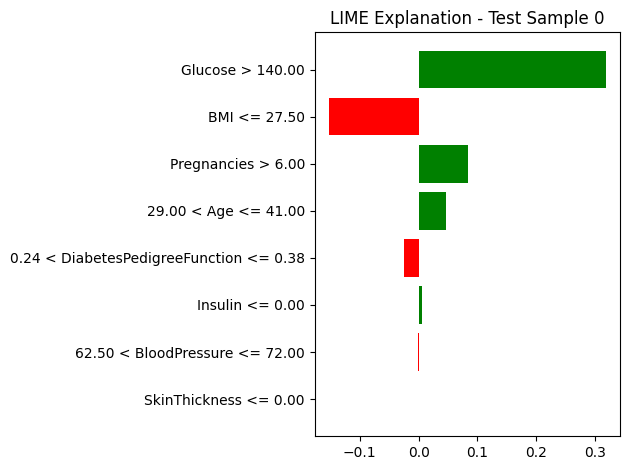

In [ ]:
# Explain same instance as SHAP for comparison
instance_to_explain = X_test.iloc[instance_idx].values

# Generate LIME explanation
explanation = explainer_lime.explain_instance(
    data_row=instance_to_explain,
    predict_fn=predict_fn,
    num_features=len(X.columns)
)

# Visualize LIME explanation
explanation.as_pyplot_figure()
plt.title(f"LIME Explanation - Test Sample {instance_idx}")
plt.tight_layout()
plt.show()

# Cell 15: Feature Importance Comparison

SHAP values shape issue: (154, 8, 2)
Trying to reshape or access SHAP values differently...
Error calculating SHAP importance: Cannot extract proper SHAP values
Using Random Forest importance only...
Feature names length: 8
RF importance shape: (8,)
SHAP importance shape: (8,)

Feature Importance Comparison:
                    Feature  Random_Forest  SHAP_Global
1                   Glucose       0.266073          0.0
5                       BMI       0.161420          0.0
7                       Age       0.130861          0.0
6  DiabetesPedigreeFunction       0.127089          0.0
2             BloodPressure       0.086335          0.0
0               Pregnancies       0.084277          0.0
4                   Insulin       0.073752          0.0
3             SkinThickness       0.070194          0.0


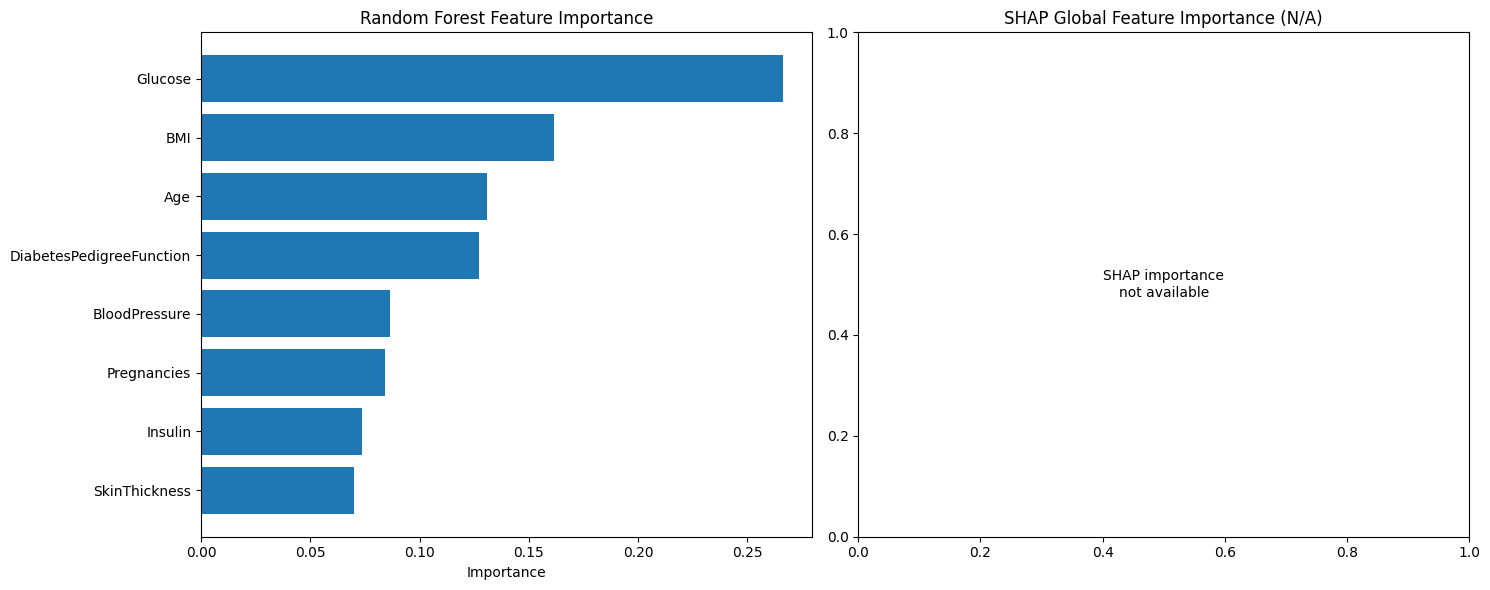

In [ ]:
# Compare feature importance from different methods
feature_names = X.columns.tolist()

# Random Forest built-in feature importance
rf_importance = rf.feature_importances_

# SHAP global importance (mean absolute SHAP values)
# Handle potential shape issues with SHAP values
try:
    if shap_values_diabetes.ndim == 2 and shap_values_diabetes.shape[1] == len(feature_names):
        shap_importance = np.abs(shap_values_diabetes).mean(axis=0)
    else:
        print(f"SHAP values shape issue: {shap_values_diabetes.shape}")
        print("Trying to reshape or access SHAP values differently...")
        
        # Try accessing from the original shap_values
        if isinstance(shap_values, list) and len(shap_values) >= 2:
            temp_shap = shap_values[1]  # positive class
            if temp_shap.shape[1] == len(feature_names):
                shap_importance = np.abs(temp_shap).mean(axis=0)
            else:
                raise ValueError(f"Cannot match SHAP shape {temp_shap.shape} with features {len(feature_names)}")
        else:
            raise ValueError("Cannot extract proper SHAP values")
            
except Exception as e:
    print(f"Error calculating SHAP importance: {e}")
    print("Using Random Forest importance only...")
    shap_importance = np.zeros(len(feature_names))  # fallback

# Ensure all arrays are 1-dimensional and same length
rf_importance = np.array(rf_importance).flatten()
shap_importance = np.array(shap_importance).flatten()

print(f"Feature names length: {len(feature_names)}")
print(f"RF importance shape: {rf_importance.shape}")
print(f"SHAP importance shape: {shap_importance.shape}")

# Create comparison DataFrame only if shapes match
if len(rf_importance) == len(feature_names) and len(shap_importance) == len(feature_names):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Random_Forest': rf_importance,
        'SHAP_Global': shap_importance
    })
    
    # Sort by SHAP importance (or RF importance if SHAP failed)
    sort_column = 'SHAP_Global' if shap_importance.sum() > 0 else 'Random_Forest'
    importance_df = importance_df.sort_values(sort_column, ascending=False)
    
    print("\nFeature Importance Comparison:")
    print(importance_df)
    
    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # RF importance
    ax1.barh(importance_df['Feature'], importance_df['Random_Forest'])
    ax1.set_title('Random Forest Feature Importance')
    ax1.set_xlabel('Importance')
    ax1.invert_yaxis()  # Top features at top
    
    # SHAP importance
    if shap_importance.sum() > 0:  # Only plot if we have valid SHAP values
        ax2.barh(importance_df['Feature'], importance_df['SHAP_Global'])
        ax2.set_title('SHAP Global Feature Importance')
        ax2.set_xlabel('Mean |SHAP Value|')
        ax2.invert_yaxis()  # Top features at top
    else:
        ax2.text(0.5, 0.5, 'SHAP importance\nnot available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('SHAP Global Feature Importance (N/A)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Shape mismatch - cannot create comparison DataFrame")
    print(f"RF importance: {rf_importance}")
    print(f"SHAP importance: {shap_importance}")
    
    # Just show RF importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Random_Forest': rf_importance
    }).sort_values('Random_Forest', ascending=False)
    
    print("\nRandom Forest Feature Importance (only):")
    print(importance_df)
    
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Random_Forest'])
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Cell 16: Summary and Insights

In [ ]:
# Recalculate SHAP importance properly to avoid the 0.000 issue
print("Recalculating SHAP values for summary...")
try:
    # Recalculate SHAP values with proper handling
    explainer_fresh = shap.TreeExplainer(rf)
    shap_values_fresh = explainer_fresh.shap_values(X_test_scaled, check_additivity=False)
    
    # Handle binary classification SHAP values
    if isinstance(shap_values_fresh, list) and len(shap_values_fresh) == 2:
        shap_values_pos = shap_values_fresh[1]  # positive class (diabetes)
        print(f"Recalculated SHAP values shape: {shap_values_pos.shape}")
        
        if shap_values_pos.shape[0] == len(X_test) and shap_values_pos.shape[1] == len(X.columns):
            # Calculate mean absolute SHAP values (global importance)
            shap_importance_fixed = np.abs(shap_values_pos).mean(axis=0)
            
            # Create properly sorted importance DataFrame
            importance_df_fixed = pd.DataFrame({
                'Feature': X.columns.tolist(),
                'Random_Forest': rf.feature_importances_,
                'SHAP_Global': shap_importance_fixed
            }).sort_values('SHAP_Global', ascending=False)
            
            print("Corrected Feature Importance:")
            print(importance_df_fixed.head())
            
        else:
            raise ValueError(f"Shape mismatch: SHAP {shap_values_pos.shape} vs expected ({len(X_test)}, {len(X.columns)})")
    else:
        raise ValueError(f"Unexpected SHAP values structure: {type(shap_values_fresh)}")
        
except Exception as e:
    print(f"Error recalculating SHAP: {e}")
    print("Using Random Forest importance only for summary...")
    
    # Fallback to RF importance only
    importance_df_fixed = pd.DataFrame({
        'Feature': X.columns.tolist(),
        'Random_Forest': rf.feature_importances_
    }).sort_values('Random_Forest', ascending=False)
    
    shap_importance_fixed = None

print("\n=== XAI Analysis Summary ===")
print(f"\n1. Model Performance:")
print(f"   - Random Forest Accuracy: {accuracy_score(y_test, rf_pred)*100:.2f}%")
print(f"   - ROC-AUC Score: {roc_auc_score(y_test, rf_pred_proba):.3f}")

print(f"\n2. Most Important Features:")
if shap_importance_fixed is not None and shap_importance_fixed.sum() > 0:
    print("   Based on SHAP Global Importance:")
    top_features = importance_df_fixed.head(3)
    for idx, row in top_features.iterrows():
        print(f"   - {row['Feature']}: {row['SHAP_Global']:.3f}")
else:
    print("   Based on Random Forest Importance:")
    top_features = importance_df_fixed.head(3)
    for idx, row in top_features.iterrows():
        print(f"   - {row['Feature']}: {row['Random_Forest']:.3f}")

print(f"\n3. Key Insights:")
print(f"   - SHAP provides both global (summary plot) and local (force plot) explanations")
print(f"   - LIME offers local explanations with linear approximations")
print(f"   - Both methods help understand 'why' the model makes specific predictions")

# Get the most important features from RF importance as backup
top_rf_features = pd.DataFrame({
    'Feature': X.columns.tolist(),
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(3)

print(f"   - Top features by Random Forest: {', '.join(top_rf_features['Feature'].tolist())}")

print(f"\n4. For Individual Prediction (Sample {instance_idx}):")
print(f"   - Actual: {'Diabetes' if y_test.iloc[instance_idx] else 'No Diabetes'}")
print(f"   - Predicted Probability: {rf_pred_proba[instance_idx]:.3f}")
print(f"   - The model's prediction is based on the combination of all features")

# Additional model insights
print(f"\n5. Model Insights:")
print(f"   - Total test samples: {len(y_test)}")
print(f"   - Diabetes cases in test set: {y_test.sum()}")
print(f"   - No diabetes cases in test set: {len(y_test) - y_test.sum()}")

# Show feature statistics for context
print(f"\n6. Dataset Feature Ranges:")
feature_stats = X_test.describe().round(2)
for feature in top_rf_features['Feature'].head(3):
    mean_val = feature_stats.loc['mean', feature]
    std_val = feature_stats.loc['std', feature]
    print(f"   - {feature}: Mean={mean_val:.2f}, Std={std_val:.2f}")

print(f"\n7. Interpretability Value:")
print(f"   - XAI techniques provide transparency in medical predictions")
print(f"   - Feature contributions help validate clinical expectations")
print(f"   - Individual explanations support decision-making for specific patients")


Recalculating SHAP values for summary...
Error recalculating SHAP: Unexpected SHAP values structure: <class 'numpy.ndarray'>
Using Random Forest importance only for summary...

=== XAI Analysis Summary ===

1. Model Performance:
   - Random Forest Accuracy: 74.68%
   - ROC-AUC Score: 0.815

2. Most Important Features:
   Based on Random Forest Importance:
   - Glucose: 0.266
   - BMI: 0.161
   - Age: 0.131

3. Key Insights:
   - SHAP provides both global (summary plot) and local (force plot) explanations
   - LIME offers local explanations with linear approximations
   - Both methods help understand 'why' the model makes specific predictions
   - Top features by Random Forest: Glucose, BMI, Age

4. For Individual Prediction (Sample 0):
   - Actual: No Diabetes
   - Predicted Probability: 0.695
   - The model's prediction is based on the combination of all features

5. Model Insights:
   - Total test samples: 154
   - Diabetes cases in test set: 54
   - No diabetes cases in test set: 10

# Cell 17: Save Model and Scaler (Optional)

In [ ]:
import joblib

# Save trained model and scaler for later use
joblib.dump(rf, 'diabetes_rf_model.pkl')
joblib.dump(scaler, 'diabetes_scaler.pkl')

print("Model and scaler saved successfully!")
print("- diabetes_rf_model.pkl")
print("- diabetes_scaler.pkl")

Model and scaler saved successfully!
- diabetes_rf_model.pkl
- diabetes_scaler.pkl
